In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mixsol import Powder, Solution, Weigher, Mixer, calculate_molar_mass

# Powder Weighing

In [2]:
powders = [
    Powder('Cs_I'),
    Powder('Pb_I2'),
    Powder('Pb_Br2'),
    Powder('Pb_Cl2'),
    Powder(
        formula='MA_I',
        molar_mass=calculate_molar_mass('C_H6_N_I'),
        alias='MAI',
    ),
    Powder(
        formula='FA_I',
        molar_mass = calculate_molar_mass('C_H5_N2_I'),
        alias='FAI',
        )
]

weigher = Weigher(
    powders=powders
)

In [3]:
target=Solution(
    solutes='Cs0.05_FA0.8_MA0.15_Pb_I2.4_Br0.45_Cl0.15',
    solvent='DMF9_DMSO1',
    molarity=1
)

answer = weigher.get_weights(
    target,
    volume=1e-3, #in L
)
print(answer) #masses of each powder, in grams

{'Cs_I': 0.012990496098, 'Pb1_I2': 0.322706258, 'Pb_Br2': 0.082576575, 'Pb_Cl2': 0.020857935, 'MAI': 0.02384543385, 'FAI': 0.1375746568}


In [4]:
target.solutes

{'Cs': 0.05,
 'FA': 0.8,
 'MA': 0.15,
 'Pb': 1.0,
 'I': 2.4,
 'Br': 0.45,
 'Cl': 0.15}

In [5]:
result = weigher.weights_to_solution(
    weights=answer,
    volume=1e-3,
    solvent='DMF9_DMSO1',
    # molarity=
)
print(result)

2.4M MA0.0625_Cs0.0208_Pb0.417_Cl0.0625_Br0.188_FA0.333_I in DMF0.9_DMSO0.1


In [6]:
result2 = weigher.weights_to_solution(
    weights=answer,
    volume=1e-3,
    solvent='DMF9_DMSO1',
    molarity='Pb'
)
print(result2)

1M MA0.15_Cs0.05_Pb_Cl0.15_Br0.45_FA0.8_I2.4 in DMF0.9_DMSO0.1


In [9]:
result == result2

True

# Solutions

In [10]:
stock_solutions = [
    Solution(
        solutes='FA_Pb_I3',
        solvent='DMF9_DMSO1',
        molarity=1,
        alias='FAPI'
    ),
    Solution(
        solutes='MA_Pb_I3',
        solvent='DMF9_DMSO1',
        molarity=1,
        alias='MAPI'
    ),
    
]

# densetargets = []
# for a in np.logspace(0, -3, 10):
#     densetargets.append(Solution(
#         solutes=f"FA{a:0.3f}_MA{1-a:.3f}_Pb_I3",
#         solvent="DMF9_DMSO1",
#         molarity=1,
#         alias=f'FA_{a:.3f}'
#     ))


densetargets = []
for a in np.linspace(0, 0.8, 4):
    densetargets.append(Solution(
        solutes=dict(
            FA=a, 
            MA=1-a, 
            Pb=1, 
            I=3),
        solvent="DMF9_DMSO1",
        molarity=1,
        # alias=f'FA_{a:.3f}'
    ))    

In [15]:
sm = Mixer(stock_solutions, {t:60 for t in densetargets})

In [16]:
sm.solve(min_volume=20, max_inputs = 3, strategy="prefer_stock")

In [27]:
sm.print()

===== Stock Prep =====
96.00 of 1M FA_Pb_I3 in DMF0.9_DMSO0.1
144.00 of MAPI
====== Mixing =====
Distribute 1M FA_Pb_I3 in DMF0.9_DMSO0.1:
	61.71 to 1M FA0.533_MA0.467_Pb_I3 in DMF0.9_DMSO0.1
	34.29 to 1M FA0.8_MA0.2_Pb_I3 in DMF0.9_DMSO0.1
Distribute MAPI:
	54.00 to 1M FA0.533_MA0.467_Pb_I3 in DMF0.9_DMSO0.1
	60.00 to 1M MA_Pb_I3 in DMF0.9_DMSO0.1
	30.00 to 1M FA0.267_MA0.733_Pb_I3 in DMF0.9_DMSO0.1
Distribute 1M FA0.533_MA0.467_Pb_I3 in DMF0.9_DMSO0.1:
	30.00 to 1M FA0.267_MA0.733_Pb_I3 in DMF0.9_DMSO0.1
	25.71 to 1M FA0.8_MA0.2_Pb_I3 in DMF0.9_DMSO0.1


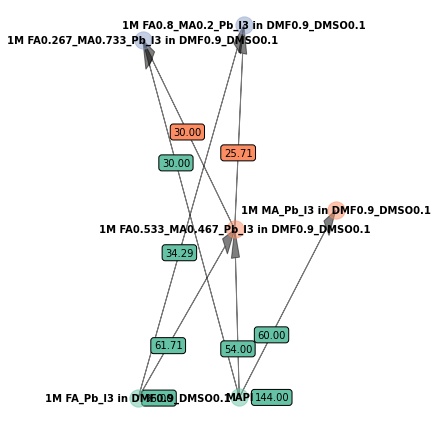

In [28]:
fig, ax = plt.subplots(figsize=(6,6))
sm.plot(ax=ax)